In [15]:
import csv
import pandas as pd
import math
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
import keras
import numpy as np
import sys 
from sklearn import svm
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.metrics import f1_score

In [16]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Model
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import torch.optim as optim

In [17]:
cuda =True

In [18]:
pho_path = './data/train_photos'
bus_path = './data/train.csv'
pho_label = 'photo_tag.csv' 
pho_bus = './data/train_photo_to_biz_ids.csv'

In [19]:
#############read the train business we need for classification
#############we can first get 1500 of them as training set and 500 of them as validation set
bus = pd.read_csv(bus_path)
img_tag = pd.read_csv(pho_label)
img_bus = pd.read_csv(pho_bus)

In [20]:
######separate training and testing set based on the business_id
train = list(bus.head(1500)['business_id'])
test = list(bus.head(500)['business_id'])
total = list(bus['business_id'])
total_label = list(bus['labels'])

In [21]:
#########filter the business, remove every business with zero label and zero image
def filter_business(total_business,total_label):
    new_bus = []
    new_label = []
    for t_b,t_l in zip(total_business,total_label):
        if type(t_l) == float or len(img_bus.loc[img_bus['business_id']==t_b])==0:
            continue
        else:
            new_bus.append(t_b)
            new_label.append(t_l)
    return new_bus,new_label

In [22]:
total,total_label = filter_business(total,total_label)

In [23]:
vgg = VGG16(weights='imagenet',include_top=False)

In [25]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
input_size = 25088 ########default feature size for VGG
output = 9
class model_dnn(nn.Module):
    #####the layer should cntain the size for each layer including input and output
    #####the hidden layer should have 3 layers
    def __init__(self, dropout=0, hidden1=2048, hidden2 = 1024 , hidden3 = 256, hidden4 = 128, output=9, 
                 num_layers=1, input_size = input_size ,type_model='LSTM'):
        super(model_dnn, self).__init__()
        
        #self.word_embeddings = nn.Embedding(len(char2idx), Embedding_size)
        self.hidden1 = hidden1
        #if type_model=="LSTM":
        self.rnn=nn.LSTM(
                        input_size=input_size,
                        hidden_size=hidden1,
                        num_layers=num_layers,
                        dropout=dropout)
        self.trans = nn.Linear(input_size,hidden1)
        
        self.dense1 = nn.Linear(hidden1,hidden2)
        self.regular = nn.Linear(hidden2,hidden3)
        self.atten = nn.Linear(hidden2,hidden3)
        #self.mult = torch.mm(hidden3,hidden3)
        self.dense4 = nn.Linear(hidden3,hidden4)
        self.last = nn.Linear(hidden3,output)
        
        
        self.dense2 = nn.Linear(hidden2+hidden1,hidden3)
        self.dense3 = nn.Linear(hidden3+hidden2,output)
        
        #self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.type_model=type_model
        #self.init_hidden()
        
    def forward(self, input_feature):
        x1, new_hidden = self.rnn(input_feature)
        
        #########second layer
        x2 = self.dense1(x1)
        
        ######### multiply 
        reg = self.regular(x2)
        att = self.atten(x2)
        
        mult = torch.mul(reg,att)  ##1 X N X 256
        
        ######get sum
        sum_f = torch.sum(mult,dim=1) ##1 X 1 X 256
        #x4 = self.dense4(sum_f)
        x5 = self.last(sum_f) ##1 X 1 X 9
        
        return x5#,new_hidden
    
    def init_hidden(self):
        if self.type_model=="LSTM":
            self.hidden = (Variable(torch.zeros(self.num_layers,1,self.hidden1).cuda())
                        ,Variable(torch.zeros(self.num_layers,1,self.hidden1)).cuda())
        else:
            self.hidden = Variable(torch.zeros(self.num_layers,1,self.hidden1).cuda())
    

def var(x,option):
    ####after this the x should have 3 dimension
    x = Variable(torch.from_numpy(np.array([x]))).float()
    if cuda and option == 'keras':
        return x.cuda()
    else:
        return x

In [26]:
###############load the model
model = torch.load('model_LSTM+FC.pt')

In [28]:
train_num = 1000
test_num = 200
img_num = 100

In [29]:
count = 0
for b_id in total[train_num:train_num+test_num]:
    img_list = list(img_bus.loc[img_bus['business_id']==b_id]['photo_id'])
    print('b_id is {0:1d}, number of photos is {1:1d}, index is {2:1d}'.format(b_id,len(img_list),count))
    count+=1

b_id is 280, number of photos is 411, index is 0
b_id is 2803, number of photos is 28, index is 1
b_id is 2804, number of photos is 33, index is 2
b_id is 2805, number of photos is 119, index is 3
b_id is 2806, number of photos is 33, index is 4
b_id is 2808, number of photos is 42, index is 5
b_id is 2810, number of photos is 8, index is 6
b_id is 281, number of photos is 167, index is 7
b_id is 2812, number of photos is 820, index is 8
b_id is 2813, number of photos is 249, index is 9
b_id is 28, number of photos is 16, index is 10
b_id is 2814, number of photos is 127, index is 11
b_id is 2817, number of photos is 92, index is 12
b_id is 2820, number of photos is 43, index is 13
b_id is 2826, number of photos is 65, index is 14
b_id is 2828, number of photos is 59, index is 15
b_id is 2829, number of photos is 104, index is 16
b_id is 2830, number of photos is 29, index is 17
b_id is 2833, number of photos is 81, index is 18
b_id is 2837, number of photos is 69, index is 19
b_id is 

In [30]:
###########only output nine photos
def plot_img(business_id):
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    num = 11
    if num>len(img_list):
        num = len(img_list)
    position = 1
    plt.figure(figsize=(15,15))
    for img in img_list[:num]:
        test_img = cv2.imread(pho_path+'/'+str(img)+'.jpg')
        test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        plt.subplot(3,4,position)
        plt.imshow(cv2.resize(test_img,(224,224)))
        plt.axis('off')
        position+=1
    plt.show()

In [32]:
############# one hot here should be multi hot :)
def get_one_hot(total_label):
    labels = []
    count = 0
    for t_l in total_label:
        l = [0 for i in range(9)]
        #print(count)
        for t in t_l.split(' '):
            #print(t)
            l[int(t)]=1
        count+=1
        labels.append(l)
    return labels

In [33]:
total_one_hot = get_one_hot(total_label)

In [34]:
label_text = ['0:good_for_lunch',
              '1:good_for_dinner',
              '2:takes_reservations',
              '3:outdoor_seating',
              '4:restaurant_is_expensive',
              '5:has_alcohol',
              '6:has_table_service',
              '7:ambience_is_classy',
              '8:good_for_kids']

In [35]:
def show_label(result,label_text):
    for r,t in zip(result[0],label_text):
        if r==1:
            print('      '+t)

In [36]:
##################test the sample image
def sample_map(model,model_extractfeatures,business_id,img_num):
    #bus_feature = []
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    img_set = []
    if len(img_list)>img_num:
        num = img_num
    else:
        num = len(img_list)
    for img in img_list[:num]:
        test_img = cv2.imread(pho_path+'/'+str(img)+'.jpg')
        #print(test_img)
        x = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        x = cv2.resize(x,(224,224))
        bus_feature = model_extractfeatures.predict(np.array([x]))
        bus_feature = np.reshape(bus_feature,(bus_feature.shape[0],bus_feature.shape[1]*bus_feature.shape[2]*bus_feature.shape[3]))
        result = model(var(bus_feature,'pytorch'))
        plt.imshow(x)
        #plt.title(str(get_result(result[0])))
        plt.axis('off')
        plt.show()
        show_label(get_result(result[0]),label_text)

In [37]:
def sample_map_all(model,model_extractfeatures,business_id,business_index):
    img_list = list(img_bus.loc[img_bus['business_id']==business_id]['photo_id'])
    img_set = []
    num = len(img_list)
    bus_f_total = []
    for img in img_list[:num]:
        test_img = cv2.imread(pho_path+'/'+str(img)+'.jpg')
        #print(test_img)
        x = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
        x = cv2.resize(x,(224,224))
        bus_feature = model_extractfeatures.predict(np.array([x]))
        bus_feature = np.reshape(bus_feature,(bus_feature.shape[0],bus_feature.shape[1]*bus_feature.shape[2]*bus_feature.shape[3]))
        bus_f_total.append(bus_feature)
    result = model(var(np.array(bus_f_total[0]),'pytorch'))
    print(total_label[business_index])
    show_label(get_result(result[0]),label_text)

In [39]:
############transform the output from probability to one-hot vector
############define a threshold to set the label as 1 with probability higher than threshold
def get_result(output,threshold = None):
    out = []
    #print()
    if len(list(output.size())) == 1:
        ave = output.data.numpy().sum()/9
        for r in output.data.numpy():
            if r<ave:
                out.append(0)
            else:
                out.append(1)
        return np.array([out])
    
    if threshold == None:
        ####use the average of each output set
        for o in output:
            ave = o.data.numpy().sum()/9
            hot = []
            for r in o.data.numpy():
                if r<ave:
                    hot.append(0)
                else:
                    hot.append(1)
            out.append(hot)
    else:
        for o in output:
            hot = []
            for r in o.data.numpy():
                if r<threshold:
                    hot.append(0)
                else:
                    hot.append(1)
            out.append(hot)
    return out

1 2 3 5 6 8
      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


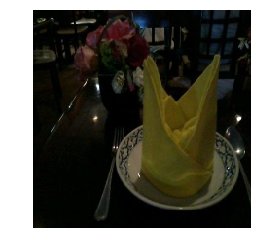

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


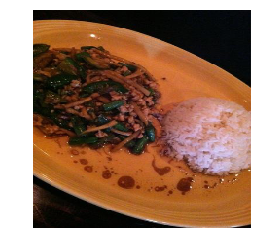

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


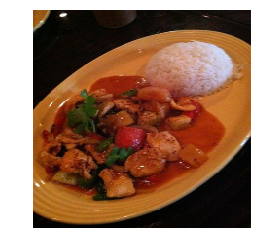

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service
      7:ambience_is_classy


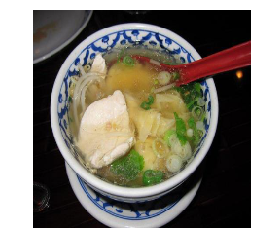

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


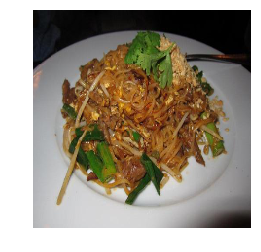

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service
      7:ambience_is_classy


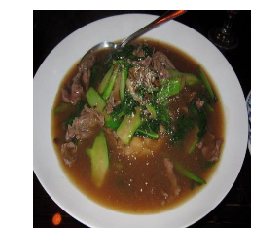

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


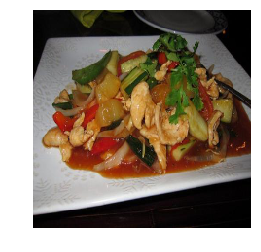

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


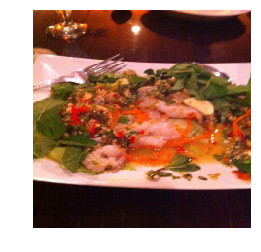

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


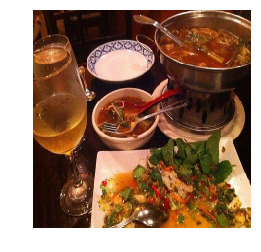

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


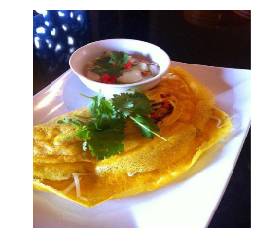

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


In [40]:
sample_map_all(model,vgg,3149,184)
sample_map(model,vgg,3149,10)

0 1 2 3 5 6
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


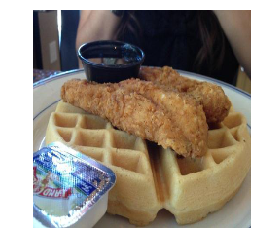

      5:has_alcohol
      6:has_table_service
      8:good_for_kids


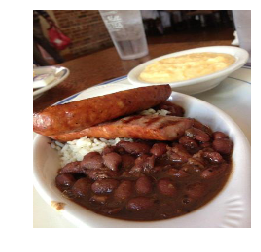

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


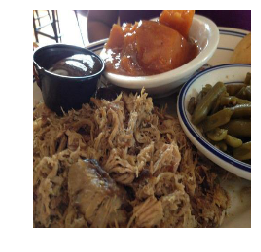

      3:outdoor_seating
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


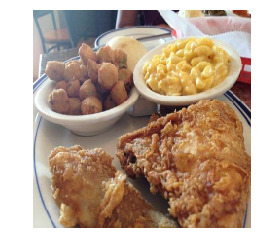

      2:takes_reservations
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


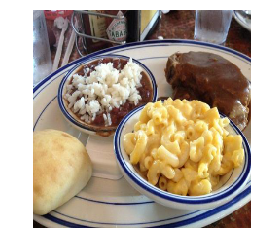

      2:takes_reservations
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


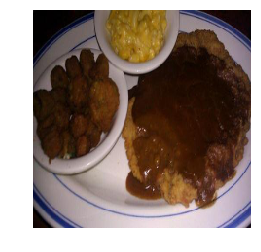

      2:takes_reservations
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


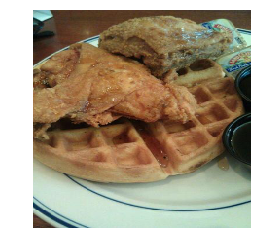

      2:takes_reservations
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


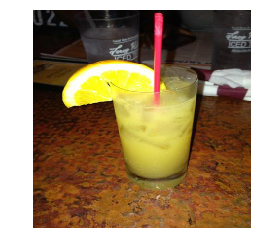

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


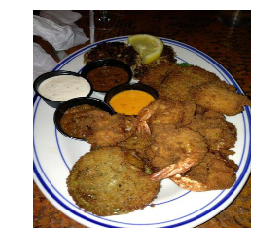

      1:good_for_dinner
      2:takes_reservations
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


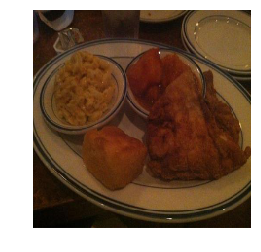

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service
      7:ambience_is_classy


In [41]:
sample_map_all(model,vgg,2854,29)
sample_map(model,vgg,2854,10)

1 8
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


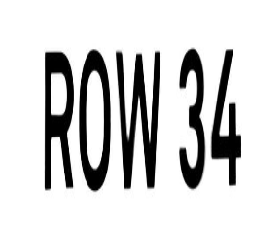

      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


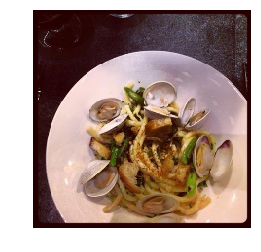

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service
      7:ambience_is_classy


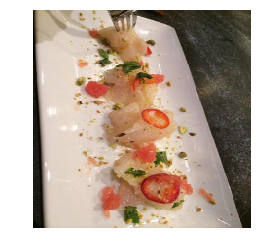

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


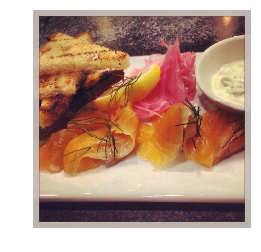

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


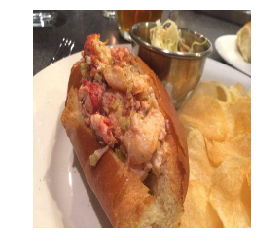

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


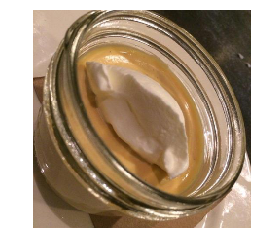

      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


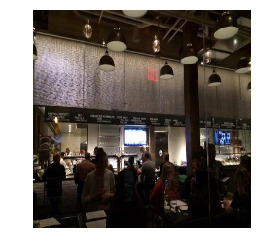

      2:takes_reservations
      5:has_alcohol
      6:has_table_service
      8:good_for_kids


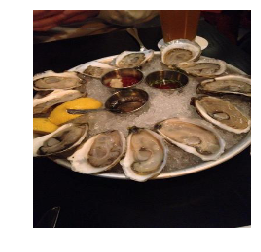

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service


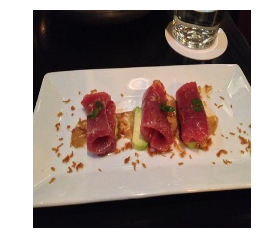

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service
      7:ambience_is_classy


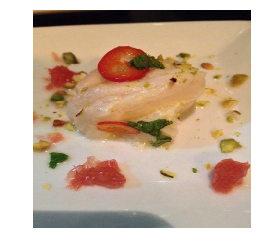

      1:good_for_dinner
      2:takes_reservations
      4:restaurant_is_expensive
      5:has_alcohol
      6:has_table_service
      7:ambience_is_classy


In [42]:
sample_map_all(model,vgg,304,129)
sample_map(model,vgg,304,10)